# Function Testing

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import argopy
import scipy.ndimage as filter
import scipy
import matplotlib
from importlib import reload

In [2]:
import funcs
import filt_funcs as ff
reload(funcs)
reload(ff)

<module 'filt_funcs' from '/home.ufs/amf2288/argo-intern/filt_funcs.py'>

## Load aselect example data

In [3]:
#glider data
ds_660_grid = xr.open_dataset('ctd_660_vert_4m_binned_29_june_2021.nc')
gselect=ds_660_grid.sel(dives=slice(50,450),ctd_pressure=slice(200,900))

#argo box
box=xr.open_dataset("202206_lon:(30,40)_lat:(-55,-50).nc")
aselect=ff.get_ds_interp(box,0,2000,4)

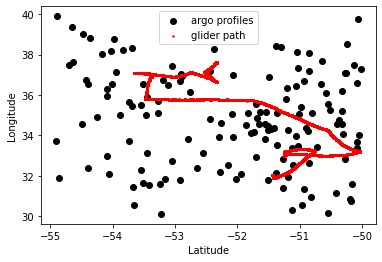

In [4]:
plt.scatter(aselect.LATITUDE,aselect.LONGITUDE,color='black',label='argo profiles')
plt.scatter(gselect.latitude,gselect.longitude,color='r',s=2,label='glider path')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend()

## Dhruv's filtering method

In [5]:
dx = (aselect.PRES_INTERPOLATED.isel(PRES_INTERPOLATED=1)-aselect.PRES_INTERPOLATED.isel(PRES_INTERPOLATED=0)).values
N = len(aselect.PRES_INTERPOLATED) +1
lfilter = 50*dx
sigmafilter = lfilter/np.sqrt(12)

nfilter_hat = lfilter/dx 
nfilter_gauss = sigmafilter/dx

f_hat = funcs.top_hat_kernel(nfilter_hat, N/2-1)
f_gauss = funcs.gaussian_kernel(nfilter_gauss, N/2-1)

In [6]:
f1 = aselect.TEMP.isel(N_PROF=0)
f1_num = int(f1.N_PROF_NEW)

f1_hat = funcs.my_filter1d(f1.values, nfilter_hat, funcs.top_hat_kernel, mode='wrap')
f1_gauss = funcs.my_filter1d(f1.values, nfilter_gauss, funcs.gaussian_kernel, mode='wrap')

f2 = aselect.TEMP.isel(N_PROF=120)
f2_num = int(f2.N_PROF_NEW)

f2_hat = funcs.my_filter1d(f2.values, nfilter_hat, funcs.top_hat_kernel, mode='wrap')
f2_gauss = funcs.my_filter1d(f2.values, nfilter_gauss, funcs.gaussian_kernel, mode='wrap')

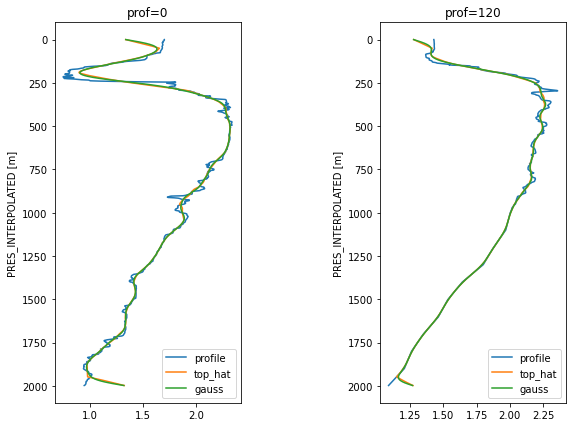

In [7]:
plt.figure(figsize=(15,7))
x=aselect.PRES_INTERPOLATED

plt.subplot(1,3,1)
plt.plot(f1, x, label='profile')
plt.plot(f1_hat, x, label='top_hat')
plt.plot(f1_gauss, x, label='gauss')
plt.gca().invert_yaxis()
plt.ylabel('PRES_INTERPOLATED [m]')
plt.title("prof={}".format(f1_num))
plt.legend()

plt.subplot(1,3,2)
plt.plot(f2, x, label='profile')
plt.plot(f2_hat, x, label='top_hat')
plt.plot(f2_gauss, x, label='gauss')
plt.gca().invert_yaxis()
plt.ylabel('PRES_INTERPOLATED [m]')
plt.title("prof={}".format(f2_num))
plt.legend()

plt.subplots_adjust(wspace=0.75)

## Filtering Functions

#### Create Mask

In [8]:
def get_mask(ds, scale, dim2='PRES_INTERPOLATED', bound=False):
    
    if bound==False:
        mask = np.ones((len(ds[dim2])))
        
    if bound==True:
        start = ds[dim2].isel({dim2:0}).values + (scale-1)
        end = ds[dim2].isel({dim2:-1}) - (scale-1)
        mask = ds[dim2].where(ds[dim2]>start).where(ds[dim2]<end).values
        
        mask[np.greater(mask,0)] = 1
        mask[np.isnan(mask)] = 0
    
    return mask

#### Create filter scales

In [9]:
def get_lfilters(first, last, num, log=False):
    
    if log==False:
        lfilters = np.linspace(first, last, num)
        
    if log==True:
        first_exp = np.log10(first)
        last_exp = np.log10(last)
        lfilters = np.logspace(first_exp, last_exp, num)
        
    return lfilters

In [10]:
def get_nfilter(ds, lfilter, dim2='PRES_INTERPOLATED'):
    
    dx = (ds[dim2].isel({dim2:1})-ds[dim2].isel({dim2:0})).values
    sigmafilter = lfilter/np.sqrt(12)
    nfilter = sigmafilter/dx
    
    return nfilter

#### Filter at one scale

In [43]:
def get_filt_prof(prof, lfilter, variable='TEMP', dim1='N_PROF', dim2='PRES_INTERPOLATED', bound=True):
    
    mask = get_mask(prof, lfilter, dim2=dim2, bound=bound)
    
    nfilter = get_nfilter(prof, lfilter, dim2=dim2)
    
    prof_filt = filter.gaussian_filter1d(prof, sigma=nfilter, mode='wrap')
    
    return prof_filt

In [11]:
def get_filt_single(ds, lfilter, variable='TEMP', dim1='N_PROF', dim2='PRES_INTERPOLATED', bound=False):
    
    mask = get_mask(ds, lfilter, dim2=dim2, bound=bound)
    
    nfilter = get_nfilter(ds, lfilter, dim2=dim2)
    
    temp = np.zeros((ds[dim1].shape[0], ds[dim2].shape[0]))
    temp[:,:] = filter.gaussian_filter1d(ds[variable], sigma=nfilter, mode='wrap')
    
    ds_filt = xr.DataArray(temp, dims=['N_PROF', 'PRES_INTERPOLATED'], coords={'N_PROF':ds[dim1], 'PRES_INTERPOLATED':ds[dim2]})
    
    number=np.arange(0,len(ds_filt.N_PROF))
    ds_filt['N_PROF_NEW']=xr.DataArray(number,dims=ds[dim1].dims)
    ds_filt['MASK']=xr.DataArray(mask,dims=ds_filt[dim2].dims)
    
    return ds_filt

In [12]:
single_filt = get_filt_single(aselect, 100, bound=True)

#### Filter at multiple scales

In [16]:
#should probably add some documentation to these, especially to specify which dim is filtered
def get_filt_multi(ds, first, last, num, variable='TEMP', dim1='N_PROF', dim2='PRES_INTERPOLATED', bound=False, log=False):
    
    lfilters = get_lfilters(first=first, last=last, num=num, log=log)
    mask = get_mask(ds, lfilter[-1], dim2=dim2, bound=bound)
    
    temp=np.zeros((ds[dim1].shape[0],ds[dim2].shape[0],num))
    for n in range(0,num):
        temp[:,:,n] = get_filt_single(ds=ds, lfilter=lfilters[n], variable=variable, dim1=dim1, dim2=dim2, bound=bound)
    
    ds_filt = xr.DataArray(temp, dims=['N_PROF', 'PRES_INTERPOLATED', 'FILT_SCALE'], 
                           coords={'N_PROF':ds[dim1], 'PRES_INTERPOLATED':ds[dim2], 'FILT_SCALE':lfilters})
    
    number=np.arange(0,len(ds[dim1]))
    ds_filt['N_PROF_NEW']=xr.DataArray(number,dims=ds[dim1].dims)
    ds_filt['MASK']=xr.DataArray(mask,dims=ds[dim2].dims)
    
    return ds_filt

In [14]:
multi_lin_False = get_filt_multi(aselect, 10,500,50)
multi_log_False = get_filt_multi(aselect, 10,500,50, log=True)

multi_lin_True = get_filt_multi(aselect, 10,500,50, bound=True)
multi_log_True = get_filt_multi(aselect, 10,500,50, bound=True, log=True)

In [15]:
multi_lin_True

<xarray.DataArray (N_PROF: 144, PRES_INTERPOLATED: 1000, FILT_SCALE: 50)>
array([[[1.42907822, 1.3775332 , 1.36017823, ..., 1.24439394,
         1.24526644, 1.24634802],
        [1.59242439, 1.4740026 , 1.4260968 , ..., 1.24620259,
         1.24705577, 1.24812198],
        [1.67110813, 1.55428064, 1.48681271, ..., 1.24801874,
         1.24885464, 1.24990702],
        ...,
        [0.98290396, 1.09857261, 1.16564417, ..., 1.23901474,
         1.23995662, 1.24109519],
        [1.05986011, 1.17869782, 1.22645199, ..., 1.24079978,
         1.24171662, 1.24283457],
        [1.22169054, 1.27504027, 1.29241586, ..., 1.24259293,
         1.24348664, 1.24458551]],

       [[1.82183754, 1.83952475, 1.84579432, ..., 1.94454014,
         1.94813573, 1.95171773],
        [1.76717293, 1.80666161, 1.8229928 , ..., 1.94444132,
         1.94807792, 1.9516983 ],
        [1.74055982, 1.77925801, 1.80200243, ..., 1.94437897,
         1.94805562, 1.95171344],
...
        [1.72494352, 2.07678199, 2.28227782, ..., 2.50556707,
         2.50057721, 2.49569702],
        [1.96614087, 2.32448983, 2.47070527, ..., 2.51188159,
         2.50665212, 2.50154448],
        [2.46278048, 2.62145519, 2.67509437, ..., 2.51814318,
         2.51267648, 2.50734329]],

       [[1.12856412, 1.1403321 , 1.14587653, ..., 1.17345607,
         1.17576742, 1.17824507],
        [1.09627116, 1.12042415, 1.13172603, ..., 1.17161381,
         1.17400551, 1.17656314],
        [1.08066523, 1.1040926 , 1.11891186, ..., 1.16979456,
         1.17226779, 1.17490649],
        ...,
        [1.22167909, 1.20121372, 1.18963516, ..., 1.17911339,
         1.18119085, 1.1834352 ],
        [1.20331621, 1.18289292, 1.17553508, ..., 1.17720675,
         1.17936087, 1.18168187],
        [1.16989601, 1.16193032, 1.16071987, ..., 1.17532063,
         1.17755282, 1.17995155]]])
Coordinates:
  * N_PROF             (N_PROF) int64 608 645 646 647 ... 1937 1939 1941 1951
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 0 2 4 6 ... 1992 1994 1996 1998
  * FILT_SCALE         (FILT_SCALE) float64 10.0 20.0 30.0 ... 480.0 490.0 500.0
    N_PROF_NEW         (N_PROF) int64 0 1 2 3 4 5 6 ... 138 139 140 141 142 143
    MASK               (PRES_INTERPOLATED) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0

## Compare Dhruv's functions to mine

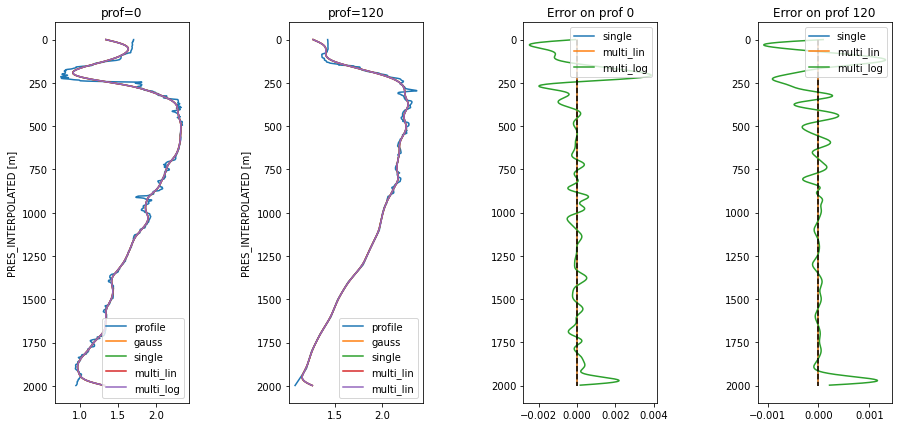

In [164]:
plt.figure(figsize=(15,7))
x=aselect.PRES_INTERPOLATED

plt.subplot(1,4,1)
plt.plot(f1, x, label='profile')
plt.plot(f1_gauss, x, label='gauss')
plt.plot(single_filt.isel(N_PROF=f1_num), x, label='single')
plt.plot(multi_lin_False.isel(N_PROF=f1_num).sel(FILT_SCALE=100.), x, label='multi_lin')
plt.plot(multi_log_False.isel(N_PROF=f1_num).isel(FILT_SCALE=29), x, label='multi_log')
plt.gca().invert_yaxis()
plt.ylabel('PRES_INTERPOLATED [m]')
plt.title("prof={}".format(f1_num))
plt.legend()

plt.subplot(1,4,2)
plt.plot(f2, x, label='profile')
plt.plot(f2_gauss, x, label='gauss')
plt.plot(single_filt.isel(N_PROF=f2_num), x, label='single')
plt.plot(multi_lin_False.isel(N_PROF=f2_num).sel(FILT_SCALE=100.), x, label='multi_lin')
plt.plot(multi_log_False.isel(N_PROF=f2_num).isel(FILT_SCALE=29), x, label='multi_lin')
plt.gca().invert_yaxis()
plt.ylabel('PRES_INTERPOLATED [m]')
plt.title("prof={}".format(f2_num))
plt.legend()

plt.subplot(1,4,3)
plt.plot(single_filt.isel(N_PROF=f1_num)-f1_gauss, aselect.PRES_INTERPOLATED, label='single')
plt.plot(multi_lin_False.isel(N_PROF=f1_num).sel(FILT_SCALE=100.)-f1_gauss, aselect.PRES_INTERPOLATED, label='multi_lin')
plt.plot(multi_log_False.isel(N_PROF=f1_num).isel(FILT_SCALE=29)-f1_gauss, aselect.PRES_INTERPOLATED, label='multi_log')
plt.vlines(0,0,2000, linestyles='dashed', color='black')
plt.gca().invert_yaxis()
plt.title("Error on prof {}".format(f1_num))
plt.legend()

plt.subplot(1,4,4)
plt.plot(single_filt.isel(N_PROF=f2_num)-f2_gauss, aselect.PRES_INTERPOLATED, label='single')
plt.plot(multi_lin_False.isel(N_PROF=f2_num).sel(FILT_SCALE=100.)-f2_gauss, aselect.PRES_INTERPOLATED, label='multi_lin')
plt.plot(multi_log_False.isel(N_PROF=f2_num).isel(FILT_SCALE=29)-f2_gauss, aselect.PRES_INTERPOLATED, label='multi_log')
plt.vlines(0,0,2000, linestyles='dashed', color='black')
plt.gca().invert_yaxis()
plt.title("Error on prof {}".format(f2_num))
plt.legend()

plt.subplots_adjust(wspace=0.75)

Text(0.5, 1.0, 'multi_log')

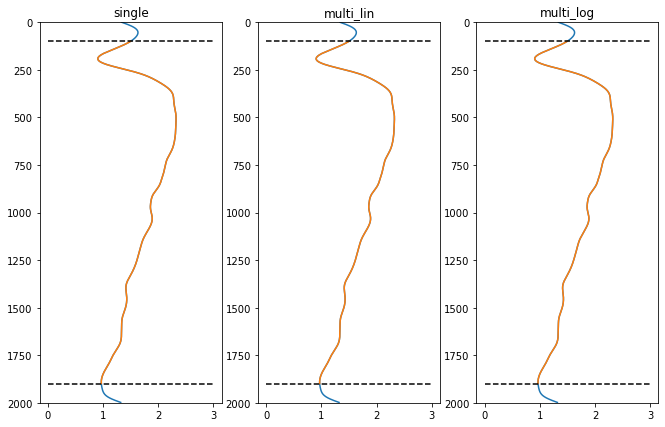

In [184]:
plt.figure(figsize=(15,7))
x=aselect.PRES_INTERPOLATED

plt.subplot(1,4,1)
plt.plot(single_filt.isel(N_PROF=f1_num),x)
plt.plot(single_filt.isel(N_PROF=f1_num).where(single_filt.MASK==1),x)
plt.hlines(100,0,3,linestyles='dashed',color='black')
plt.hlines(1900,0,3,linestyles='dashed',color='black')
plt.ylim(0,2000)
plt.gca().invert_yaxis()
plt.title('single')

plt.subplot(1,4,2)
plt.plot(multi_lin_False.isel(N_PROF=f1_num).sel(FILT_SCALE=100.),x)
plt.plot(multi_lin_True.isel(N_PROF=f1_num).sel(FILT_SCALE=100.).where(single_filt.MASK==1),x)
plt.hlines(100,0,3,linestyles='dashed',color='black')
plt.hlines(1900,0,3,linestyles='dashed',color='black')
plt.ylim(0,2000)
plt.gca().invert_yaxis()
plt.title('multi_lin')

plt.subplot(1,4,3)
plt.plot(multi_log_False.isel(N_PROF=f1_num).isel(FILT_SCALE=29),x)
plt.plot(multi_log_True.isel(N_PROF=f1_num).isel(FILT_SCALE=29).where(single_filt.MASK==1),x)
plt.hlines(100,0,3,linestyles='dashed',color='black')
plt.hlines(1900,0,3,linestyles='dashed',color='black')
plt.ylim(0,2000)
plt.gca().invert_yaxis()
plt.title('multi_log')